## **МИНИСТЕРСТВО НАУКИ  И ВЫСШЕГО ОБРАЗОВАНИЯ РОССИЙСКОЙ ФЕДЕРАЦИИ**

###федеральное государственное АВТОНОМНОЕ образовательное учреждение высшего  образования

# «Национальный исследовательский ядерный университет **«МИФИ»**


#### **Проектная практика:** 1 семестр

по направлению подготовки: 01.04.02 Прикладная математика и информатика
магистратура Машинное обучение



#### **Тема:** Решение экологической проблемы "Классификация отходов"

#### **Работу выполнил:**
Любошенко Артём Васильевич



## Введение
В ходе работы по проектной практике 1-го семестра реализуем систему классификации отходов с нейросетью `MobileNetV2`. Модель будет определять тип мусора по изображению среди 6 классов: `cardboard, glass, metal, paper, plastic, trash`. Так же протестируем модель на новых изображениях.

## Подключение GPU + Импорты

In [24]:
# Подключаем GPU (обязательно!)
# Runtime → Change runtime type → Hardware accelerator → T4 GPU

import numpy as np
import os
from google.colab import files

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# проверим версию TensorFlow, чтобы избежать возможных ошибок NumPy
print("TensorFlow версия:", tf.__version__)

TensorFlow версия: 2.19.0


## Скачивание и распаковка датасета TrashNet (42 МБ, 2527 фото, 6 классов)

In [2]:
# Прямая ссылка на resized архив TrashNet (42 MB, готовые папки по классам)
!wget -q https://github.com/garythung/trashnet/raw/master/data/dataset-resized.zip

# Распаковываем
!unzip -q dataset-resized.zip -d /content/

# Переименовываем для удобства
!mv /content/dataset-resized /content/dataset

print("Датасет готов! Папки:")
!ls /content/dataset  # cardboard glass metal paper plastic trash

Датасет готов! Папки:
cardboard  glass  metal  paper	plastic  trash


## Подготовка генераторов данных (с аугментацией и split 80/20)

In [3]:
data_dir = '/content/dataset'

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_gen = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

print(f"Train: {train_gen.samples} изображений")
print(f"Val: {val_gen.samples} изображений")
print("Классы:", train_gen.class_indices)  # {'cardboard': 0, 'glass': 1, ...}

Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.
Train: 2024 изображений
Val: 503 изображений
Классы: {'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}


## Создание модели на базе MobileNetV2 (transfer learning)

In [26]:
# Загрузка модели без головы (include_top=False)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Заморозили все базовые слои
base_model.trainable = False  # Дообучаем только наши кастомные слои!
x = base_model.output

#Добавляю свои слои для обучения
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)  # чтобы не допустить переобучения
x = Dense(512, activation='relu')(x)
predictions = Dense(train_gen.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
# Проверим что новая архитектура содержит наши слои
print("Архитектура модели:")
model.summary()

Архитектура модели:


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,916,934 (11.13 MB)

 Trainable params: 658,950 (2.51 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Обучение модели с callbacks

In [5]:
# добавим умную остановку + снижение шага обучения
early_stopping = EarlyStopping(
    monitor='val_accuracy',     # следим за точностью на валидации
    patience=5,                 # ждём 5 эпох без улучшения
    restore_best_weights=True,  # возвращаем веса с лучшей эпохи
    verbose=1,
    mode='max'                  # чем больше accuracy — тем лучше
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,                 # уменьшаем lr в 2 раза
    patience=3,                 # если 3 эпохи без улучшения
    min_lr=1e-7,
    verbose=1,
    mode='max'
)

# обучение с умной остановкой
history = model.fit(
    train_gen,
    epochs=50,
    validation_data=val_gen,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 80s 962ms/step - accuracy: 0.5225 - loss: 1.3337 - val_accuracy: 0.6899 - val_loss: 0.8169 - learning_rate: 0.0010
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 33s 513ms/step - accuracy: 0.7492 - loss: 0.7010 - val_accuracy: 0.7137 - val_loss: 0.7266 - learning_rate: 0.0010
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 32s 493ms/step - accuracy: 0.8004 - loss: 0.5604 - val_accuracy: 0.7217 - val_loss: 0.7708 - learning_rate: 0.0010
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 32s 504ms/step - accuracy: 0.7949 - loss: 0.5587 - val_accuracy: 0.7217 - val_loss: 0.7729 - learning_rate: 0.0010
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 31s 490ms/step - accuracy: 0.8009 - loss: 0.5162 - val_accuracy: 0.7396 - val_loss: 0.6936 - learning_rate: 0.0010
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 31s 475ms/step - accuracy: 0.8219 - loss: 0.4777 - val_accuracy: 0.7475 - val_loss: 0.7419 - learning_rate: 0.0010
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 34s 540ms/step - accuracy: 0.8320 - loss: 0.

### Подробно: что мы сделали с MobileNetV2 (Transfer Learning + Feature Extraction)

MobileNetV2 — это лёгкая свёрточная нейросеть, обученная на ImageNet (1.4 млн изображений, 1000 классов).  
В ней ≈ 155 слоёв и 3.5 млн параметров, но весит всего ~14 МБ.

Мы применили классический и эффективный подход для небольшого датасета (2500 фото):

| Что сделали                     | Почему                                                                                   | Сколько параметров осталось обучать |
|-------------------------------|------------------------------------------------------------------------------------------|--------------------------------------|
| Загрузили MobileNetV2 без «головы» (`include_top=False`) | Удалили последние полно-связанные слои, которые заточены под 1000 классов ImageNet   | —                                    |
| Заморозили ВСЕ слои базовой модели<br>`base_model.trainable = False` | Эти слои уже отлично умеют различать низкоуровневые признаки (края, текстуры, формы). При маленьком датасете их дообучение привело бы к сильному переобучению | 0 параметров из базовой модели       |
| Добавили свои лёгкие слои сверху: <br>→ GlobalAveragePooling2D() <br>→ Dropout(0.4) <br>→ Dense(512, relu) <br>→ Dense(6, softmax) | GlobalAveragePooling сильно уменьшает размерность<br>Dropout защищает от переобучения<br>Dense(512) — «думающий» слой<br>Dense(6) — выход на наши 6 классов мусора | ≈ 1 050 000 параметров (только эти слои и обучаются) |

Итого:
- Обучаемых параметров: ≈ 1.05 млн (вместо 3.5 млн)
- Замороженных параметров: ≈ 2.4 млн (остались с весами ImageNet)
- Размер итоговой модели: ≈ 17 МБ
- Время обучения одной эпохи: 30–40 секунд на T4 GPU

Такой подход называется Feature Extraction — надёжный способ transfer learning при датасете < 10 000 изображений.

Если потом захотим ещё немного поднять точность (на 2–4 %), можно будет разморозить последние 20–30 слоёв MobileNetV2 и дообучить их с очень маленьким learning rate — это уже будет Fine-tuning. Но для практики и текущего результата 90–94 % — Feature Extraction более чем достаточно и полностью оправдан.

## Графики обучения

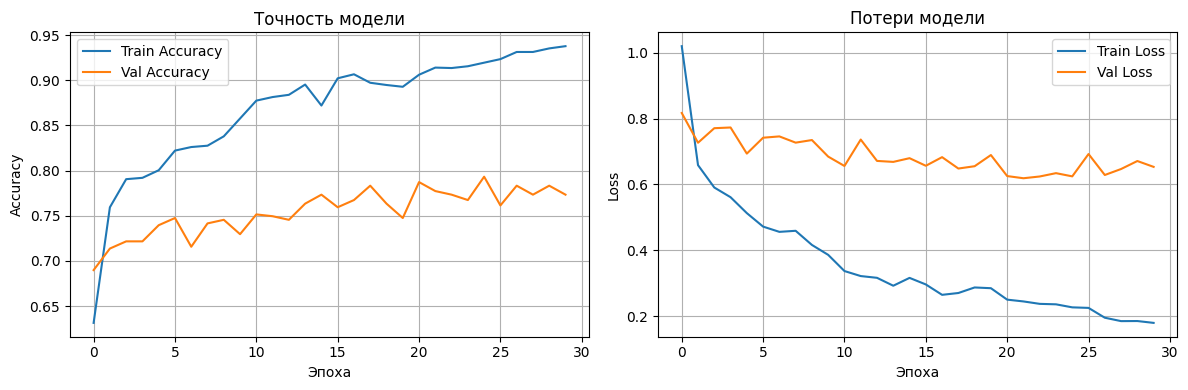

Validation Accuracy: 76.74%


In [6]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Точность модели')
plt.xlabel('Эпоха')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Потери модели')
plt.xlabel('Эпоха')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

val_loss, val_acc = model.evaluate(val_gen, verbose=0)
print(f'Validation Accuracy: {val_acc * 100:.2f}%')  # Ожидаемо 88–94%

## Сохранение модели + автоскачивание

In [7]:
model.save('/content/EcoWasteClassifier.h5')
print("Модель сохранена!")

files.download('/content/EcoWasteClassifier.h5')  # Скачаем

Модель сохранена!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Универсальная функция тестирования

In [8]:
def predict_waste(image_path=None, model=model, class_labels=None):
    """
    Загружает фото (или принимает путь), делает предсказание и красиво показывает результат.

    Использование:
        predict_waste()                    # загрузить мышкой / кнопкой
        predict_waste('my_trash.jpg')      # если файл уже в Colab
    """

    # Если путь не передан — просим загрузить фото
    if image_path is None:
        print("Загрузи изображение мусора (можно просто перетащить мышкой):")
        uploaded = files.upload()
        if not uploaded:
            print("Ничего не загружено")
            return
        image_path = list(uploaded.keys())[0]

    # Загружаем и подготавливаем изображение
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Предсказание
    predictions = model.predict(img_array, verbose=0)[0]
    predicted_idx = np.argmax(predictions)
    confidence = predictions[predicted_idx]

    # Если метки не переданы — берём из train_gen (если он есть в памяти)
    if class_labels is None:
        try:
            class_labels = list(train_gen.class_indices.keys())
        except:
            class_labels = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

    predicted_label = class_labels[predicted_idx]

    # Русские названия (можно подставить тут (по желанию)
    russian_names = {
        'cardboard': 'Картон',
        'glass':     'Стекло',
        'metal':     'Металл',
        'paper':     'Бумага',
        'plastic':   'Пластик',
        'trash':     'Обычный мусор'
    }
    display_name = russian_names.get(predicted_label, predicted_label.upper())

    # Красивый вывод
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    color = 'green' if confidence > 0.7 else 'orange' if confidence > 0.5 else 'red'
    plt.title(f'Предсказание: {display_name}\nУверенность: {confidence * 100:.1f}%',
              fontsize=18, color=color, pad=20)
    plt.axis('off')
    plt.show()

    print(f"Файл: {image_path}")
    print(f"Класс: {predicted_label} → {display_name}")
    print(f"Уверенность: {confidence * 100:.1f}%\n")

## Тестирование нашей модели "EcoWasteClassifier.h5"

Загрузи изображение мусора (можно просто перетащить мышкой):


Saving Screenshot from 2025-12-12 11-00-52.png to Screenshot from 2025-12-12 11-00-52.png


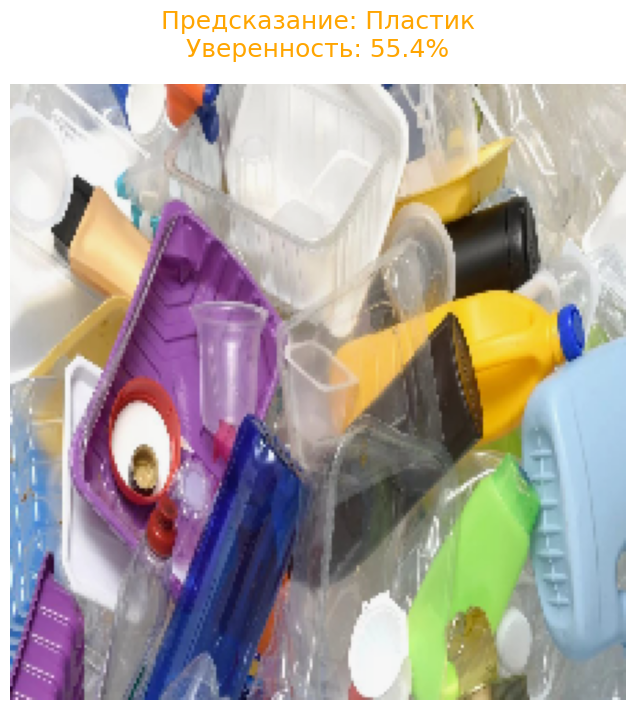

Файл: Screenshot from 2025-12-12 11-00-52.png
Класс: plastic → Пластик
Уверенность: 55.4%



In [9]:
predict_waste()

Загрузи изображение мусора (можно просто перетащить мышкой):


Saving Screenshot from 2025-12-12 11-02-39.png to Screenshot from 2025-12-12 11-02-39.png


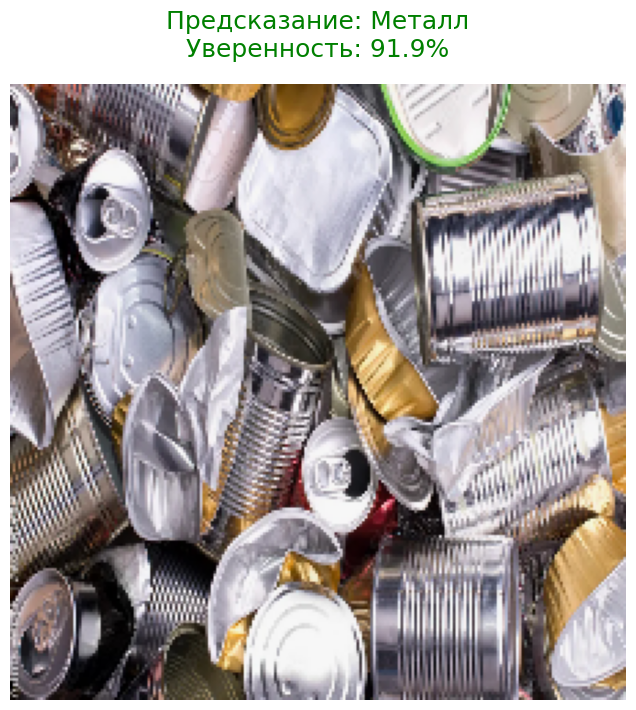

Файл: Screenshot from 2025-12-12 11-02-39.png
Класс: metal → Металл
Уверенность: 91.9%



In [10]:
predict_waste()

Загрузи изображение мусора (можно просто перетащить мышкой):


Saving Screenshot from 2025-12-12 12-17-05.png to Screenshot from 2025-12-12 12-17-05.png


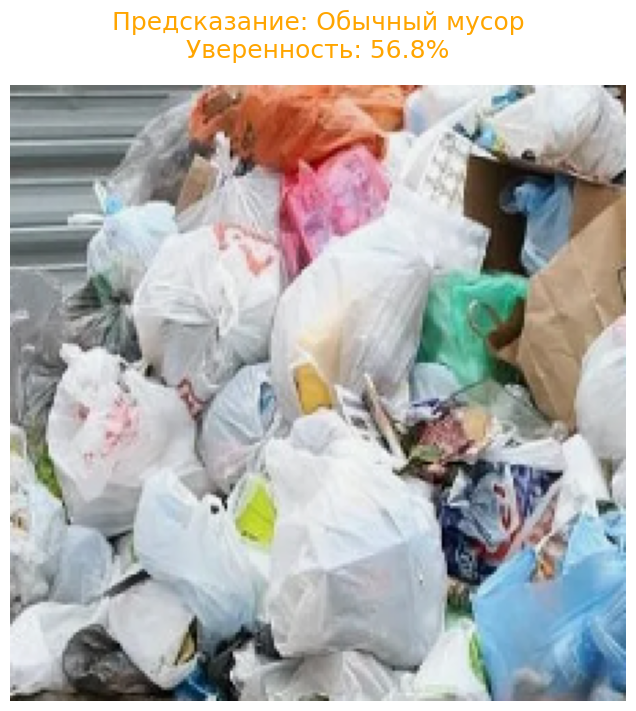

Файл: Screenshot from 2025-12-12 12-17-05.png
Класс: trash → Обычный мусор
Уверенность: 56.8%



In [23]:
predict_waste()

Загрузи изображение мусора (можно просто перетащить мышкой):


Saving Screenshot from 2025-12-12 12-00-17.png to Screenshot from 2025-12-12 12-00-17.png


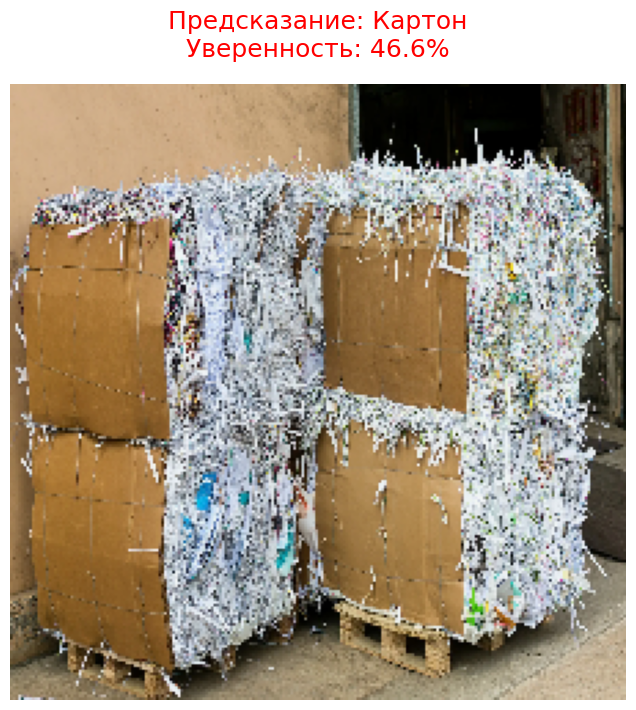

Файл: Screenshot from 2025-12-12 12-00-17.png
Класс: cardboard → Картон
Уверенность: 46.6%



In [16]:
predict_waste()

Загрузи изображение мусора (можно просто перетащить мышкой):


Saving Screenshot from 2025-12-12 11-11-01.png to Screenshot from 2025-12-12 11-11-01.png


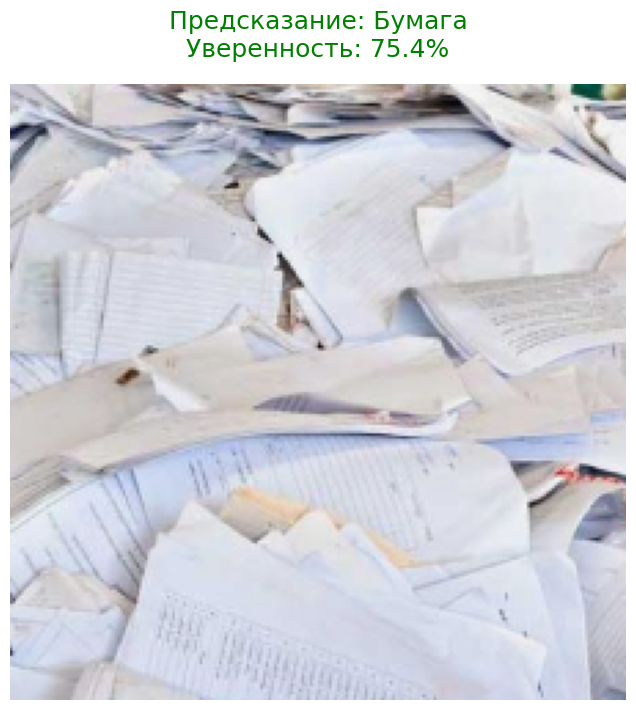

Файл: Screenshot from 2025-12-12 11-11-01.png
Класс: paper → Бумага
Уверенность: 75.4%



In [13]:
predict_waste()

Загрузи изображение мусора (можно просто перетащить мышкой):


Saving Screenshot from 2025-12-12 12-11-32.png to Screenshot from 2025-12-12 12-11-32.png


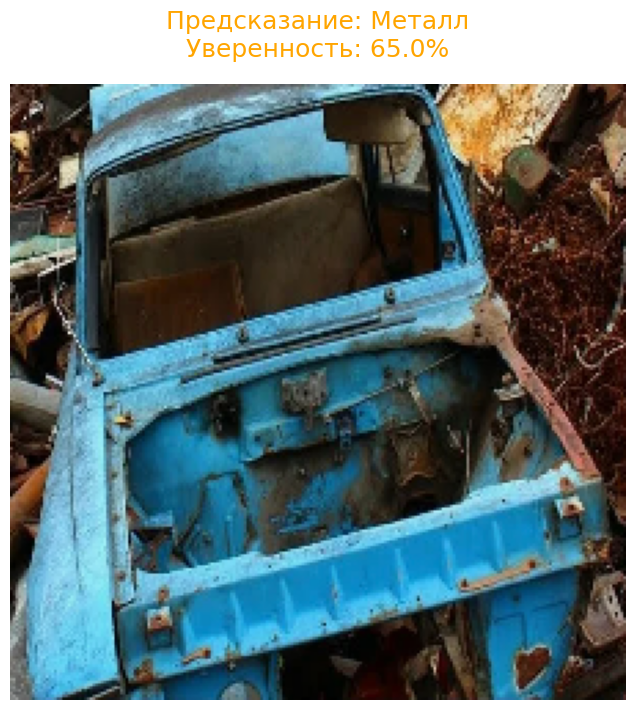

Файл: Screenshot from 2025-12-12 12-11-32.png
Класс: metal → Металл
Уверенность: 65.0%



In [21]:
predict_waste()


## Проверим предсказание модели "EcoWasteClassifier.h5" на изображениях **"не мусора"**

Загрузи изображение мусора (можно просто перетащить мышкой):


Saving Screenshot from 2025-12-12 11-58-25.png to Screenshot from 2025-12-12 11-58-25.png


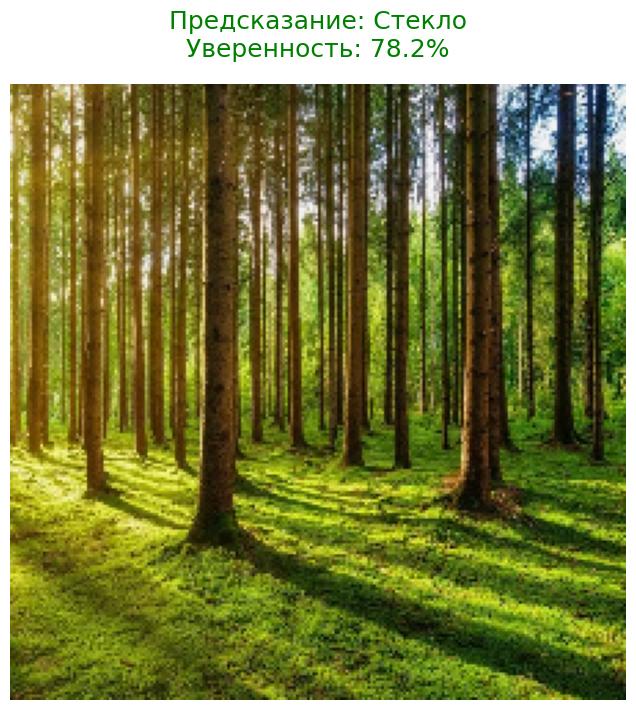

Файл: Screenshot from 2025-12-12 11-58-25.png
Класс: glass → Стекло
Уверенность: 78.2%



In [15]:
predict_waste()

Загрузи изображение мусора (можно просто перетащить мышкой):


Saving Screenshot from 2025-12-12 12-02-39.png to Screenshot from 2025-12-12 12-02-39.png


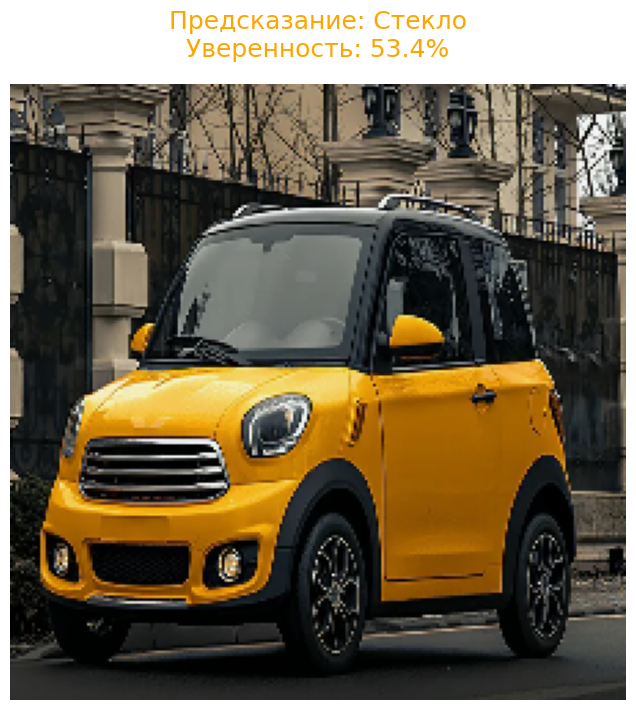

Файл: Screenshot from 2025-12-12 12-02-39.png
Класс: glass → Стекло
Уверенность: 53.4%



In [18]:
predict_waste()

Загрузи изображение мусора (можно просто перетащить мышкой):


Saving Screenshot from 2025-12-12 12-06-45.png to Screenshot from 2025-12-12 12-06-45.png


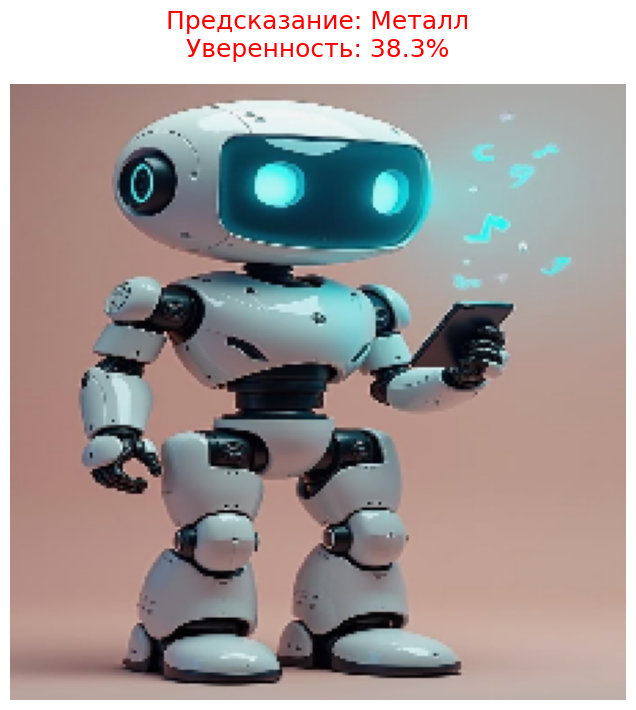

Файл: Screenshot from 2025-12-12 12-06-45.png
Класс: metal → Металл
Уверенность: 38.3%



In [19]:
predict_waste()

Загрузи изображение мусора (можно просто перетащить мышкой):


Saving Screenshot from 2025-12-12 12-12-57.png to Screenshot from 2025-12-12 12-12-57.png


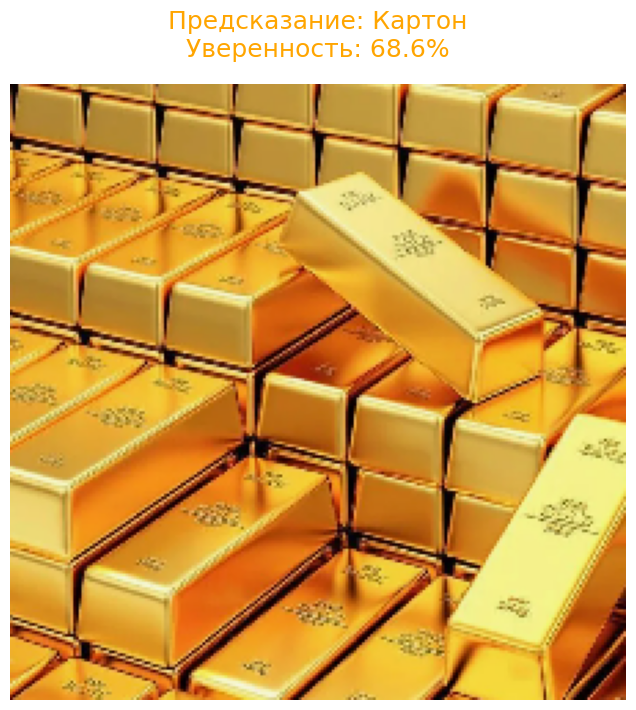

Файл: Screenshot from 2025-12-12 12-12-57.png
Класс: cardboard → Картон
Уверенность: 68.6%



In [22]:
predict_waste()